In [2]:
# plotting
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Blackjack environment

In [157]:
import os
from typing import Optional

import numpy as np
import random

import gym
from gym import spaces
from gym.error import DependencyNotInstalled


def cmp(a, b):
    return float(a > b) - float(a < b)

def draw_card(env, np_random = {}):
    #return int(np_random.choice(deck))
    return int(env.deck.pop())


def draw_hand(env, np_random = {}):
    #return [draw_card(np_random), draw_card(np_random)]
    return [draw_card(env), draw_card(env)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

def complete_point_count_system(deck):
  score = 0
  for card in deck:
    if int(card) in [1,2,3,4,5,6,7]:
      score += 1
    elif int(card) in [10,1]:
      score -= 1
    else:
      pass
  return score


class BlackjackEnv(gym.Env):
    player = []
    dealer = []

    # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
    deck = []

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        self.action_space = spaces.Discrete(2)
        # TODO: Muss ich hier etwas ändern, wenn ich anfange Karten zu zählen?
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        # shuffle deck
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        random.shuffle(self.deck)

    # Game logic for player's actions (hitting or standing).
    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        return self._get_obs(), reward, terminated, False

    # Get state
    def _get_obs(self):
        # Count the cards. 1. keep track of the number of cards left. 2. keep track of the Complete Point count system.
        # Process num_cards_left into bins, since keeping track of each single state would explode the state space
        # TODO: Play around with this
        num_cards_left = len(self.deck)
        if num_cards_left >= 40:
          num_cards_left = 40 # Many cards are left
        elif num_cards_left >= 30:
          num_cards_left = 30 # Medium cards are left
        else:
          num_cards_left = 20 # Few cards are left

        # Binning
        val_remaining_cards = complete_point_count_system(self.deck)
        if val_remaining_cards < -5: # Very good for player
          val_remaining_cards = -5
        elif val_remaining_cards >= -5 and val_remaining_cards <= 5: # Pretty much even
          val_remaining_cards = 0
        else: # very bad for player
          val_remaining_cards = 5

        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), num_cards_left, val_remaining_cards)

    # Start a new game
    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        if len(self.deck) <= 10:
            super().reset(seed=seed)
            self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
            random.shuffle(self.deck)

        # TODO: Actually 1. Dealer 2. Player 3. Dealer 4. Player should draw. Doesn't matter, though.
        self.dealer = draw_hand(self)
        self.player = draw_hand(self)

        # TODO: Hier die Logik dafür, dass immer weiter mit einem Deck gespielt wird, bis es ein Threshold erreicht, nach dem neue gemischt werden sollte = Ende einer Episode.

        return self._get_obs()[:3]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"\nenv = BlackjackEnv()\nfor i_episode in range(1):\n    env.reset()\n    while len(env.deck) > 10:\n        state = env.reset()\n\n        while True:\n            print(state)\n            action = env.action_space.sample()\n\n            state, reward, done, info = env.step(action)\n            if done:\n                print('End game! Reward: ', reward)\n                print('You won :)\n') if reward > 0 else print('You lost :(\n')\n                break\n"

### Monte Carlo

In [158]:
import sys
import gym
import numpy as np
from collections import defaultdict

#from plot_utils import plot_blackjack_values, plot_policy

In [159]:
#env = gym.make('Blackjack-v1')
env = BlackjackEnv()
print(env.deck)

[9, 10, 2, 4, 5, 10, 10, 5, 9, 10, 4, 7, 10, 7, 10, 10, 7, 8, 1, 3, 3, 4, 10, 10, 10, 10, 4, 1, 10, 5, 2, 6, 10, 2, 10, 3, 10, 8, 6, 5, 8, 6, 1, 7, 1, 8, 3, 10, 6, 9, 9, 2]


In [160]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [161]:
"""
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break
"""

"\nfor i_episode in range(3):\n    state = env.reset()\n    while True:\n        print(state)\n        action = env.action_space.sample()\n        state, reward, done, info = env.step(action)\n        if done:\n            print('End game! Reward: ', reward)\n            print('You won :)\n') if reward > 0 else print('You lost :(\n')\n            break\n"

In [168]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """
    Generates an episode from following the epsilon-greedy policy
    One episode is the player playing until the remaining deck becomes smaller than 10 cards
    """
    episode = []
    env.reset() # Reset the deck, to make sure the len(deck) > 10 again
    while len(env.deck) > 10:
      state = env.reset()
      # TODO: state so far, improve to count cards too
      state = state[0]
      while True:
          action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample()
          next_state, reward, done, info = env.step(action)
          # TODO: state so far, improve to count cards too
          next_state = next_state[:3] # Remove this for card counting
          episode.append((state, action, reward))
          state = next_state
          if done:
              break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [169]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [170]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 100000, 0.02)

Episode 4000/100000.

KeyboardInterrupt: ignored

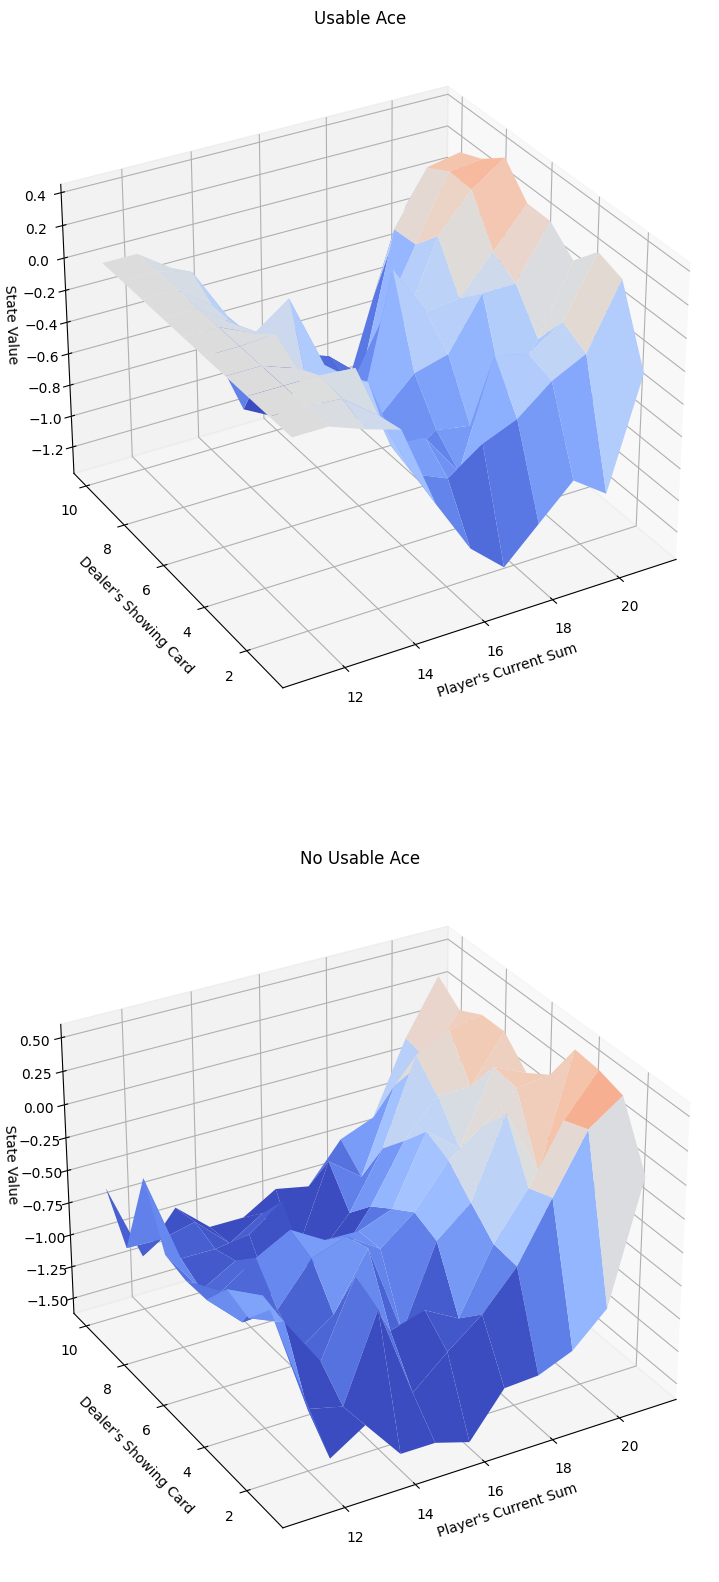

In [155]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

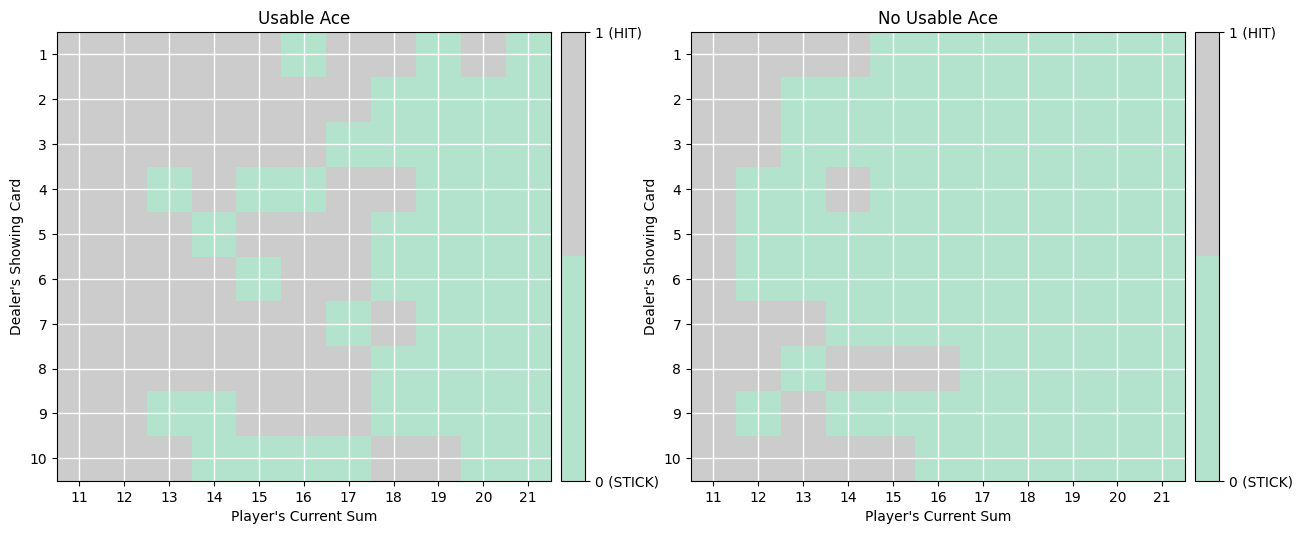

In [156]:
# plot the policy
plot_policy(policy)

### Todo's
- Train it once really long to get to the optimal policy (making sure that Monte Carlo is the right approach)
- Done - Understand the environment + Understand the code
- (Make it work locally on the macbook?)
- Recreate the environment myself to be able to add/ change rules -> Also achieve optimal policy
- Achieve the Complete Point-Count System by changing some things about the environment (like keeping track of a stack instead of sampling cards randomly. Also to add another dimension to the state which counts the cards. Also count the additional dimension based on the value of the cards.)
- Send it to the group
- Do the printing functions myself/ a little bit different
- Do some changes to the rules
- Write paper